In [145]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

## Chapter 2

In [11]:
# 3 Ls, 6Ws
# we want to find out the real proportion of water

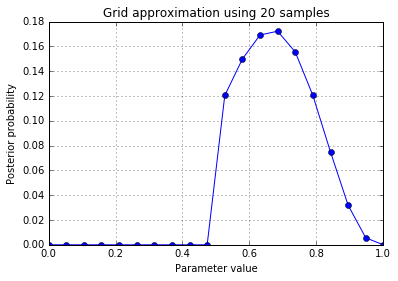

In [12]:
num_grid_samples = 20

p_grid = np.linspace(0, 1, num_grid_samples)
likelihood = [stats.binom.pmf(6, 9, p) for p in p_grid]

# prior = np.ones(20)
prior = np.where(p_grid < 0.5, 0, 1)

unstd_posterior = likelihood * prior
std_posterior = unstd_posterior / sum(unstd_posterior)

#### plotting ####

pd.Series(std_posterior, index=p_grid).plot(marker='o', markerfacecoloralt='r')
plt.xlabel('Parameter value')
plt.ylabel('Posterior probability')
plt.title('Grid approximation using %d samples' % num_grid_samples)
plt.grid();

#### Problems

In [13]:
# 2M3

p_E = 1/2
p_M = 1/2

p_land_E = 0.3
p_land_M = 1

# p(Earth|Land)

posterior = (p_land_E * p_E) / (p_land_E * p_E + p_land_M * p_M)
print(posterior)

0.23076923076923075


In [14]:
# 2H4 

# Probability of species A given a postive genetic test for A?

# P(test = A | Species = A) = 0.80
# P(test = B | Species = A) = 0.20
# P(test = B | Species = B) = 0.65
# P(test = A | Species = B) = 0.35

# P(A) = 0.5
# P(B) = 0.5

# The vet administered the test to your panda and tells you it's positive for species A. 
# What is the posterior probability that the panda is species A?

# P(Species = A | test = A) = (P(test = A | Species = A) * P(Species = A)) / 
#        ((P(test = A | Species = A) * P(Species = A)) + (P(test = A | Species = B) * P(Species = B)))


In [15]:
0.8 * 0.5 / (0.8 * 0.5 + 0.35 * 0.5)

0.6956521739130436

## Chapter 3

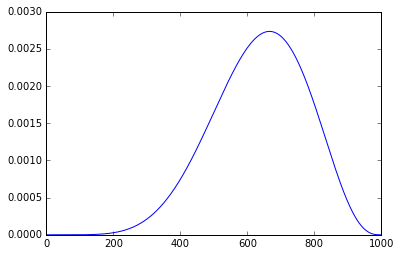

In [26]:
# R code 3.2
p_grid = np.linspace(0, 1, 1000)
likelihood = [stats.binom.pmf(6, 9, p) for p in p_grid]
prior = np.ones(1000)

unstd_posterior = likelihood * prior
std_posterior = unstd_posterior / sum(unstd_posterior)

pd.Series(std_posterior).plot()

#### Sampling from a grid-approximate posterior

In [72]:
# R code 3.3
num_samples = 100000
samples = np.random.choice(p_grid, num_samples, p=std_posterior, replace=True)

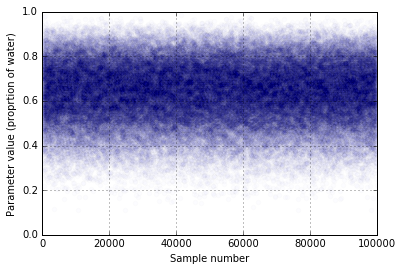

In [75]:
plt.scatter(x=range(num_samples), y=samples, alpha=0.01)
plt.xlim([0, num_samples])
plt.ylim([0, 1])

plt.ylabel('Parameter value (proprtion of water)')
plt.xlabel('Sample number')

plt.grid();

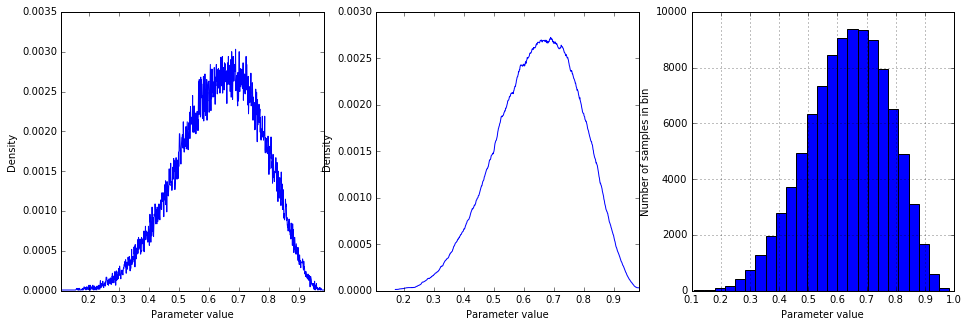

In [77]:
fig, (ax_left, ax_center, ax_right) = plt.subplots(1, 3, figsize=(16, 5))

sample_series = pd.Series(samples).value_counts().sort_index()

sample_series.div(num_samples).plot(ax=ax_left)
pd.rolling_mean(sample_series.div(num_samples), 25).plot(ax=ax_center)
pd.Series(samples).hist(bins=25, ax=ax_right);

ax_left.set_xlabel('Parameter value')
ax_left.set_ylabel('Density')

ax_center.set_xlabel('Parameter value')
ax_center.set_ylabel('Density')

ax_right.set_xlabel('Parameter value')
ax_right.set_ylabel('Number of samples in bin')

plt.show()

##### Intervals of defined boundaries

In [80]:
# R code 3.7

sum(samples < 0.5) / num_samples

0.17119999999999999

In [83]:
# R code 3.8

sum((samples > 0.5) & (samples < 0.75)) / num_samples

0.60667000000000004

In [87]:
sample_series = pd.Series(samples)

In [88]:
# R code 3.9

sample_series.quantile(0.8)

0.75975975975975973

In [92]:
# R code 3.10

sample_series.quantile([0.1, 0.9])

0.1    0.448448
0.9    0.811812
dtype: float64

In [115]:
# R code 3.11

p_grid = np.linspace(0, 1, 1000)
likelihood = stats.binom.pmf(3, 3, p_grid)
prior = np.ones(1000)

posterior = likelihood * prior
posterior = posterior / sum(posterior)

samples = np.random.choice(p_grid, 100000, p=posterior, replace=True)

[25, 75]
[ 0.70670671  0.93093093]


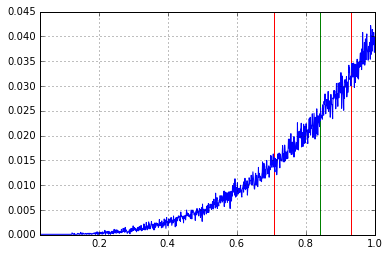

In [148]:
pd.Series(samples).value_counts().sort_index().div(10000).plot()

percentiles = np.percentile(samples, [25, 75])
print([25, 75])
print(percentiles)

# These two are the same
# np.percentile(samples, [25, 75])
# pd.Series(samples).quantile([0.25, 0.75]) 

hpd = pm.hpd(samples, alpha=0.5)

plt.vlines(percentiles[0], ymin=0, ymax=0.045, color='r')
plt.vlines(percentiles[1], ymin=0, ymax=0.045, color='r')

plt.vlines(hpd[0], ymin=0, ymax=0.045, color='g')
plt.vlines(hpd[1], ymin=0, ymax=0.045, color='g')

plt.grid();

In [136]:
# R code 3.12

np.percentile(samples, [25, 75])

array([ 0.70670671,  0.93093093])

In [147]:
# R code 3.13
pm.hpd(samples, alpha=0.5)

array([ 0.84084084,  1.        ])

##### Point estimates

In [162]:
# 3.14

# maximum a posteriori
pd.Series(posterior, index=p_grid).idxmax()

1.0

In [167]:
# 3.15

pd.Series(samples).value_counts().idxmax()

0.98798798798798793

In [171]:
# R code 3.16

print(np.mean(samples))
print(np.median(samples))

0.80003964965
0.840840840841


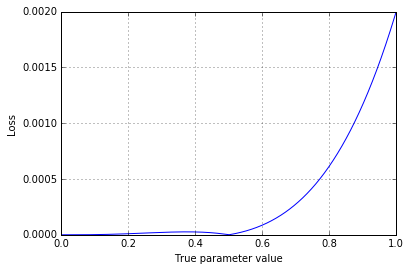

In [183]:
# Loss weighted by posterior probability of the parameter, for choice 0.5

pd.Series(posterior * np.abs(0.5 - p_grid), index=p_grid).plot()
plt.xlabel('True parameter value')
plt.ylabel('Loss')
plt.grid();

In [184]:
# Expected loss for choosing parameter 0.5
pd.Series(posterior * np.abs(0.5 - p_grid), index=p_grid).sum()

0.3128751874998122

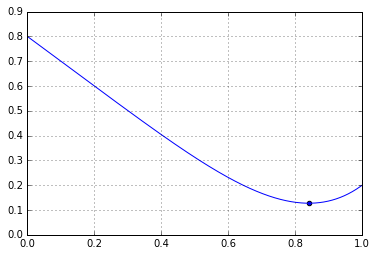

In [198]:
# R code 3.18 

loss = pd.Series([sum(posterior * np.abs(choice - p_grid)) for choice in p_grid], index=p_grid)
loss.plot()
plt.scatter(x=loss.idxmin(), y=loss.min())
plt.grid();

In [201]:
# R code 3.19

print(loss.idxmin())
print(np.median(samples))

0.840840840841
0.840840840841


#### Sampling to simulate prediction

In [205]:
# R code 3.20

stats.binom.pmf([0, 1, 2], 2, 0.7)

array([ 0.09,  0.42,  0.49])

In [211]:
# R code 3.22

stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 1, 2, 2, 2, 2, 2, 1, 2, 2])

In [219]:
# R code 3.23

dummy_w = stats.binom.rvs(n=2, p=0.7, size=10000)
pd.Series(dummy_w).value_counts().div(10000)

2    0.4922
1    0.4133
0    0.0945
dtype: float64

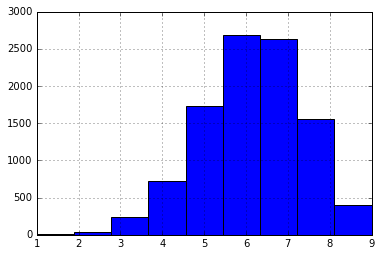

In [227]:
# R code 3.24

dummy_w = stats.binom.rvs(n=9, p=0.7, size=10000)
pd.Series(dummy_w).hist(bins=9);

The implied predictions (simulated data) of the model are uncertain in two ways:
 - Observation uncertainty - there is uncertainty in the predicted observations because even if you know p with  certainty, you don't know the next globe toss with certainty (unless p in {0,1}.
 - Parameter uncertainty
 
 To propagate the uncertainty, build **posterior predictive distribution** (which in my metaphor is the average of the likelihood, weighted by the posterior).

In [387]:
# Resetting to original example

p_grid = np.linspace(0, 1, 1000)
likelihood = [stats.binom.pmf(6, 9, p) for p in p_grid]
prior = np.ones(1000)

posterior = likelihood * prior
posterior /= sum(posterior)
posterior = pd.Series(posterior, index=p_grid)

num_samples = 10000
samples = pd.Series(np.random.choice(p_grid, num_samples, p=posterior, replace=True))

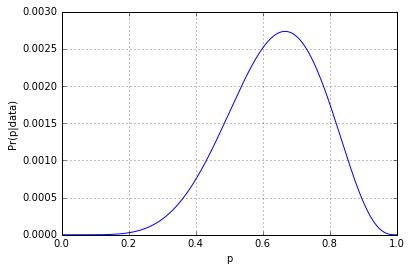

In [389]:
posterior.plot(); plt.grid(); plt.xlabel('p'); plt.ylabel('Pr(p|data)');

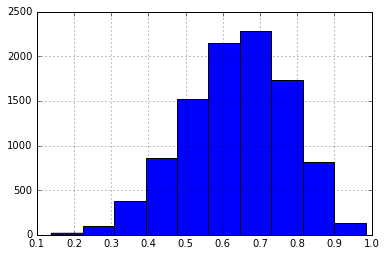

In [401]:
samples.hist()

In [ ]:
# To compute the **posterior predictive probability**, for each sample of our parameter,
# use the likelihood to generate new data predictions, and average them by the posterior
# distribution of the parameter.

Probability of new data ($x_{new}$), given observed data ($x$) and parameter ($\theta$):

$$Pr(x_{new} ~| ~x) = \int_\theta p(x_{new}~|~\theta,~x) * p(\theta~|~x) ~d\theta$$

because $x_{new}$ and $x$ are independent (independent observations/predictions of data):

$$Pr(x_{new} ~| ~x) = \int_\theta p(x_{new}~|~\theta) * p(\theta~|~x) ~d\theta$$

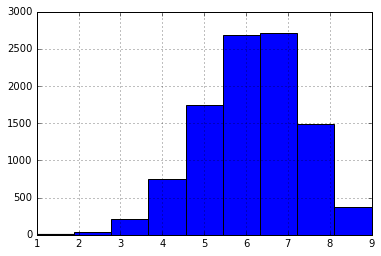

In [410]:
# sample new data for a given value of parameter p

pd.Series(stats.binom.rvs(n=9, p=0.7, size=10000)).hist(bins=9)

In [411]:
# for each sample of p drawn from the posterior, sample new data;
# - each sample p is already weighed by its posterior probability (because of how we generated the samples)
# => so the new data samples we generate are already weighed by p's posterior probability

ppd_samples = []
for p in samples:
    ppd_samples.extend(stats.binom.rvs(n=9, p=p, size=100))

ppd_samples = pd.Series(ppd_samples)

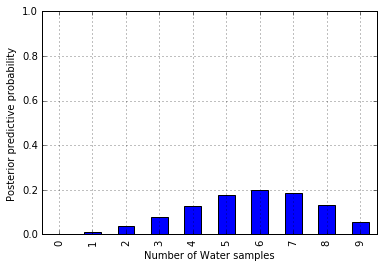

In [414]:
ppd_samples.value_counts(normalize=True).sort_index().plot(kind='bar');

plt.xlabel('Number of Water samples'); plt.ylabel('Posterior predictive probability');
plt.ylim([0,1]); plt.grid();

There is a lot of spread to the predictions, but a lot of this spread arises from the binomial process itself, not uncertainty about p. 

#### Chapter 3: Problems

In [278]:
p_grid = np.linspace(0, 1, 1000)

prior = np.ones(1000)
likelihood = stats.binom.pmf(6, 9, p_grid)

posterior = likelihood * prior
posterior /= sum(posterior)

# Set the random seed
np.random.seed(100)

num_samples = 10000
samples = np.random.choice(p_grid, num_samples, p=posterior, replace=True)

##### Easy

In [286]:
# Problem 3E1
sum(samples < 0.2) / num_samples

0.001

In [287]:
# Problem 3E2
sum(samples > 0.8) / num_samples

0.12089999999999999

In [288]:
# Problem 3E3
sum((samples > 0.2) & (samples < 0.8)) / num_samples

0.87809999999999999

In [289]:
# Problem 3E4
np.percentile(samples, 20)

0.51551551551551555

In [290]:
# Problem 3E5
np.percentile(samples, 80)

0.75975975975975973

In [291]:
# Problem 3E6
pm.hpd(samples, alpha=0.66)

array([ 0.5995996 ,  0.72672673])

In [293]:
# Problem 3E7
np.percentile(samples,[16.5, 100 - 16.5])

array([ 0.49449449,  0.77577578])

##### Medium

In [431]:
# 3M1
p_grid = np.linspace(0, 1, 1000)

prior = np.ones(1000)
likelihood = stats.binom.pmf(8, 15, p_grid)

posterior = likelihood * prior
posterior /= sum(posterior)

posterior = pd.Series(posterior, index=p_grid)

In [432]:
# 3M2

num_samples = 10000
samples = np.random.choice(p_grid, num_samples, p=posterior, replace=True)

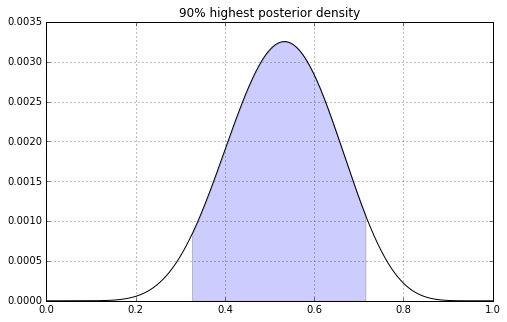

In [433]:
fig, ax = plt.subplots(figsize=(8,5))

posterior.plot(ax=ax, color='black')

hpd = pm.hpd(samples, alpha=0.1)
ax.fill_between(p_grid, y1=posterior, where=((p_grid > hpd[0]) & (p_grid < hpd[1])), alpha=0.2)

plt.title("90% highest posterior density")
plt.grid();

In [439]:
# 3M3 

ppd_samples = []

for p_sample in samples:
    ppd_samples.extend(stats.binom.rvs(n=15, p=p_sample, size=100))
    
ppd_samples = pd.Series(ppd_samples)

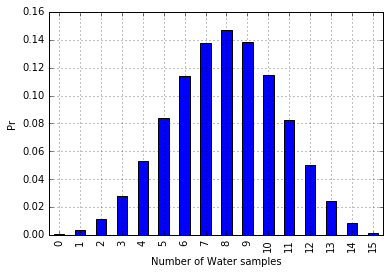

In [441]:
ppd_samples.value_counts(normalize=True).sort_index().plot(kind='bar');
plt.xlabel('Number of Water samples'); plt.ylabel('Pr');
plt.grid();

In [442]:
# 3M3 

ppd_samples = []

for p_sample in samples:
    ppd_samples.extend(stats.binom.rvs(n=9, p=p_sample, size=100))
    
ppd_samples = pd.Series(ppd_samples)

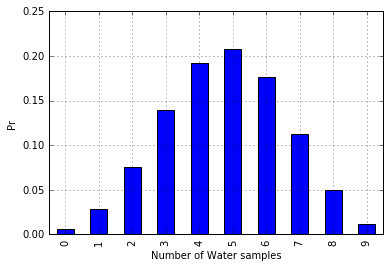

In [443]:
ppd_samples.value_counts(normalize=True).sort_index().plot(kind='bar');
plt.xlabel('Number of Water samples'); plt.ylabel('Pr');
plt.grid();

In [455]:
# 3M5

p_grid = np.linspace(0, 1, 1000)

uniform_prior = np.ones(1000)
half_prior = np.hstack([np.zeros(500), p_grid[p_grid > 0.5]])

likelihood = stats.binom.pmf(8, 15, p_grid)

u_posterior = likelihood * uniform_prior
u_posterior /= sum(u_posterior)

h_posterior = likelihood * half_prior
h_posterior /= sum(h_posterior)

u_posterior = pd.Series(u_posterior, index=p_grid)
h_posterior = pd.Series(h_posterior, index=p_grid)

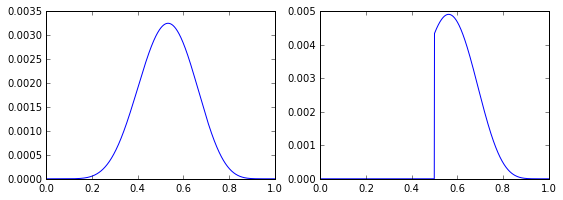

In [460]:
fig, (ax_left, ax_right) = plt.subplots(1,2, figsize=(9,3))

u_posterior.plot(ax=ax_left);
h_posterior.plot(ax=ax_right);

In [461]:
num_samples = 10000

u_samples = np.random.choice(p_grid, num_samples, p=u_posterior, replace=True)
h_samples = np.random.choice(p_grid, num_samples, p=h_posterior, replace=True)

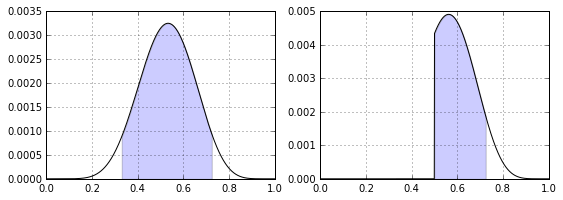

In [465]:
fig, (ax_left, ax_right) = plt.subplots(1,2, figsize=(9,3))

u_posterior.plot(ax=ax_left, color='black')
h_posterior.plot(ax=ax_right, color='black')

u_hpd = pm.hpd(u_samples, alpha=0.1)
h_hpd = pm.hpd(h_samples, alpha=0.1)

ax_left.fill_between(p_grid, y1=u_posterior, where=((p_grid > u_hpd[0]) & (p_grid < h_hpd[1])), alpha=0.2)
ax_right.fill_between(p_grid, y1=h_posterior, where=((p_grid > u_hpd[0]) & (p_grid < h_hpd[1])), alpha=0.2)

ax_left.grid();
ax_right.grid();

In [468]:
u_ppd_samples = []
h_ppd_samples = []

for p_sample in u_samples:
    u_ppd_samples.extend(stats.binom.rvs(n=15, p=p_sample, size=100))
    
for p_sample in h_samples:
    h_ppd_samples.extend(stats.binom.rvs(n=15, p=p_sample, size=100))
  
u_ppd_samples = pd.Series(u_ppd_samples)
h_ppd_samples = pd.Series(h_ppd_samples)

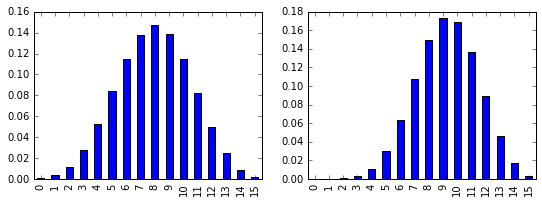

In [469]:
fig, (ax_left, ax_right) = plt.subplots(1,2, figsize=(9,3))

u_ppd_samples.value_counts(normalize=True).sort_index().plot(ax=ax_left, kind='bar')
h_ppd_samples.value_counts(normalize=True).sort_index().plot(ax=ax_right, kind='bar')

##### Hard